# PREPARATION DES DONNEES POUR LA MODELISATION

Ce notebook combine :
1. Le merge de train +les données meteo
2. Le nettoyage et la préparation des données
3. La création de features temporelles
4. La sauvegarde des datasets

In [26]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## PARTIE 1 : MERGE DES DONNEES

## Chargement des données

In [27]:
df_train = pd.read_csv('../data/raw/train.csv')

print(df_train.head(3))

# Stations météo
df_stations = pd.read_csv('../data/raw/ListedesStationsMeteo.csv', sep=';')
print(df_stations.shape)
print(df_stations.columns.tolist())
print(df_stations.head(3))

     Id    week  region_code region_name  TauxGrippe
0  5523  201152           42      ALSACE          66
1  5524  201152           72   AQUITAINE          24
2  5525  201152           83    AUVERGNE          91
(62, 5)
['ID', 'Nom', 'Latitude', 'Longitude', 'Altitude']
     ID              Nom   Latitude  Longitude  Altitude
0  7005        ABBEVILLE  50.136000   1.834000        69
1  7015    LILLE-LESQUIN  50.570000   3.097500        47
2  7020  PTE DE LA HAGUE  49.725167  -1.939833         6


# Mapping région / Station

In [28]:
REGION_STATION_MAPPING = {
    'ALSACE': ['07190', '07280'],
    'AQUITAINE': ['07510', '07630'],
    'AUVERGNE': ['07460', '07380'],
    'BASSE-NORMANDIE': ['07027', '07139'],
    'BOURGOGNE': ['07280', '07255'],
    'BRETAGNE': ['07110', '07117', '07130'],
    'CENTRE': ['07255', '07149'],
    'CHAMPAGNE-ARDENNE': ['07072', '07168'],
    'CORSE': ['07761', '07790'],
    'FRANCHE-COMTE': ['07299', '07280'],
    'HAUTE-NORMANDIE': ['07037', '07020'],
    'ILE-DE-FRANCE': ['07150', '07149'],
    'LANGUEDOC-ROUSSILLON': ['07630', '07643'],
    'LIMOUSIN': ['07434', '07335'],
    'LORRAINE': ['07090', '07180'],
    'MIDI-PYRENEES': ['07630', '07627'],
    'NORD-PAS-DE-CALAIS': ['07005', '07015'],
    'PAYS DE LA LOIRE': ['07222', '07130'],
    'PICARDIE': ['07005', '07015'],
    'POITOU-CHARENTES': ['07335', '07255'],
    "PROVENCE-ALPES-COTE D'AZUR": ['07650', '07690'],
    'RHONE-ALPES': ['07481', '07482'],
}

station_region_map = []
for region, stations in REGION_STATION_MAPPING.items():
    for station in stations:
        station_region_map.append({
            'numer_sta': station,
            'region_name': region
        })

df_station_region = pd.DataFrame(station_region_map)
print (len(df_station_region), "associations station-région")
print(f"  Régions couvertes : {df_station_region['region_name'].nunique()}")
print(df_station_region.head(10))

45 associations station-région
  Régions couvertes : 22
  numer_sta      region_name
0     07190           ALSACE
1     07280           ALSACE
2     07510        AQUITAINE
3     07630        AQUITAINE
4     07460         AUVERGNE
5     07380         AUVERGNE
6     07027  BASSE-NORMANDIE
7     07139  BASSE-NORMANDIE
8     07280        BOURGOGNE
9     07255        BOURGOGNE


### ÉTAPE 3 : Charger les données météo (SYNOP)

In [29]:
import os 
chemin_dossier = "../data/raw/DonneesMeteorologiques"

print("Fichiers dans le dossier :")
tous_fichiers = os.listdir(chemin_dossier)
for f in tous_fichiers[:10]:
    print(f"  - {f}")

# Chercher les fichiers synop
synop_files = sorted(glob.glob(os.path.join(chemin_dossier, "synop.*.csv")))

print(f"\nFichiers synop trouvés : {len(synop_files)}")

if len(synop_files) > 0:
    # Charger et concaténer
    synop_dfs = []
    for file in synop_files:
        df = pd.read_csv(file, sep=';')
        synop_dfs.append(df)
    
    df_synop = pd.concat(synop_dfs, ignore_index=True)
    print(f" Données météo SYNOP : {df_synop.shape}")
    print(f"  Colonnes : {df_synop.columns.tolist()}")
else:
    print(" Aucun fichier synop trouvé !")

Fichiers dans le dossier :
  - synop.200401.csv
  - synop.200402.csv
  - synop.200403.csv
  - synop.200404.csv
  - synop.200405.csv
  - synop.200406.csv
  - synop.200407.csv
  - synop.200408.csv
  - synop.200409.csv
  - synop.200410.csv

Fichiers synop trouvés : 154
 Données météo SYNOP : (2163605, 60)
  Colonnes : ['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4', 'Unnamed: 59']


In [30]:
print(len(synop_files))
print(synop_files[:5])

154
['../data/raw/DonneesMeteorologiques\\synop.200401.csv', '../data/raw/DonneesMeteorologiques\\synop.200402.csv', '../data/raw/DonneesMeteorologiques\\synop.200403.csv', '../data/raw/DonneesMeteorologiques\\synop.200404.csv', '../data/raw/DonneesMeteorologiques\\synop.200405.csv']


In [31]:
stations_of_interest = df_station_region['numer_sta'].unique().tolist()
stations_int = [int(s) for s in stations_of_interest]

synop_data_list = []
for file in synop_files:
    df_synop = pd.read_csv(file, sep=';', low_memory=False)
    df_synop_filtered = df_synop[df_synop['numer_sta'].isin(stations_of_interest)]
    
    if len(df_synop_filtered) == 0:
        df_synop_filtered = df_synop[df_synop['numer_sta'].isin(stations_int)]
    
    if len(df_synop_filtered) > 0:
        synop_data_list.append(df_synop_filtered)

df_synop_all = pd.concat(synop_data_list, ignore_index=True)
df_synop_all['date'] = pd.to_datetime(df_synop_all['date'], format='%Y%m%d%H%M%S', errors='coerce')

print(f"Données synop : {df_synop_all.shape}")
print(f"Stations uniques : {df_synop_all['numer_sta'].nunique()}")
print(f"Période : {df_synop_all['date'].min()} -> {df_synop_all['date'].max()}")

Données synop : (1056104, 60)
Stations uniques : 29
Période : 2004-01-01 00:00:00 -> 2016-10-27 15:00:00


### ÉTAPE 4 : Gestion des dates (les convertir en week)

In [32]:
df_synop_all['date'] = pd.to_datetime(df_synop_all['date'], format='%Y%m%d%H%M%S', errors='coerce')

# Supprimer les lignes où la date n'a pas pu être convertie
df_synop_all = df_synop_all.dropna(subset=['date'])

df_synop_all['year'] = df_synop_all['date'].dt.isocalendar().year
df_synop_all['week'] = df_synop_all['date'].dt.isocalendar().week
df_synop_all['week_year'] = df_synop_all['year'].astype(str) + df_synop_all['week'].astype(str).str.zfill(2)
df_synop_all['week_year'] = df_synop_all['week_year'].astype(int)

print(df_synop_all['week_year'].head().tolist())

[200401, 200401, 200401, 200401, 200401]


### ÉTAPE 5 : Agrégation par région et semaine

In [33]:
# S'assurer que les IDs sont au même format
df_synop_all['numer_sta'] = df_synop_all['numer_sta'].astype(str).str.zfill(5)
df_station_region['numer_sta'] = df_station_region['numer_sta'].astype(str).str.zfill(5)

# Merger avec le mapping station->région
df_synop_all = df_synop_all.merge(df_station_region, on='numer_sta', how='inner')


# Variables météo à agréger
meteo_vars = [
    'tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'n', 'nbas', 'hbas',
    'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
    'tminsol', 'tw', 'raf10', 'rafper', 'per', 'ht_neige', 'ssfrai',
    'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24'
]

meteo_vars_available = [v for v in meteo_vars if v in df_synop_all.columns]
print(f"  Variables météo disponibles : {len(meteo_vars_available)}/{len(meteo_vars)}")

# Convertir en numérique
for var in meteo_vars_available:
    df_synop_all[var] = pd.to_numeric(df_synop_all[var], errors='coerce')

# Agréger par région et semaine (moyenne)
agg_dict = {var: 'mean' for var in meteo_vars_available}
df_meteo_agg = df_synop_all.groupby(['region_name', 'week_year'], as_index=False).agg(agg_dict)

  Variables météo disponibles : 31/31


### ÉTAPE 6 : Merge final avec train.csv

In [34]:
# Normaliser les noms de régions
df_train['region_name_clean'] = df_train['region_name'].str.upper().str.strip()
df_meteo_agg['region_name_clean'] = df_meteo_agg['region_name'].str.upper().str.strip()
# Merger
df_final = df_train.merge(
    df_meteo_agg,
    left_on=['region_name_clean', 'week'],
    right_on=['region_name_clean', 'week_year'],
    how='left'
)

print(f" Merge effectué : {df_final.shape}")

# Nettoyer les colonnes dupliquées
cols_to_drop = ['region_name_clean', 'week_year', 'region_name_y']
df_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns])

if 'region_name_x' in df_final.columns:
    df_final = df_final.rename(columns={'region_name_x': 'region_name'})

# Sauvegarder
df_final.to_csv('../data/processed/train_synop_merged_inner.csv', index=False)

print(f"\nFichier généré : train_synop_merged_inner.csv")
print(f"  Dimensions : {df_final.shape}")
print(f"  Observations : {len(df_final)}")
print(f"  Variables météo ajoutées : {len(meteo_vars_available)}")

 Merge effectué : (9196, 39)

Fichier généré : train_synop_merged_inner.csv
  Dimensions : (9196, 36)
  Observations : 9196
  Variables météo ajoutées : 31


### Analyse du merge

In [35]:

print(f"  train.csv original : {len(df_train)} lignes")
print(f"  Après merge : {len(df_final)} lignes")
print(f"  Taux de couverture : {len(df_final)/len(df_train)*100:.2f}%")

print(f"\nRégions couvertes :")
print(df_final['region_name'].value_counts())

print(f"\nPériode couverte :")
print(f"  Semaines : {df_final['week'].min()} -> {df_final['week'].max()}")

print(f"\nValeurs manquantes :")
missing = df_final.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print(missing.head(10))
else:
    print("  Aucune valeur manquante!")

  train.csv original : 9196 lignes
  Après merge : 9196 lignes
  Taux de couverture : 100.00%

Régions couvertes :
region_name
ALSACE                        418
AQUITAINE                     418
AUVERGNE                      418
BASSE-NORMANDIE               418
BOURGOGNE                     418
BRETAGNE                      418
CENTRE                        418
CHAMPAGNE-ARDENNE             418
CORSE                         418
FRANCHE-COMTE                 418
HAUTE-NORMANDIE               418
LANGUEDOC-ROUSSILLON          418
LIMOUSIN                      418
LORRAINE                      418
MIDI-PYRENEES                 418
NORD-PAS-DE-CALAIS            418
PAYS-DE-LA-LOIRE              418
PICARDIE                      418
POITOU-CHARENTES              418
PROVENCE-ALPES-COTE-D-AZUR    418
ILE-DE-FRANCE                 418
RHONE-ALPES                   418
Name: count, dtype: int64

Période couverte :
  Semaines : 200401 -> 201152

Valeurs manquantes :
tend24       9196
tx24     

In [36]:
df=df_train.copy()

In [37]:
missing = pd.DataFrame({
    'missing_count': df.isnull().sum(),
    'missing_pct': df.isnull().mean() * 100
}).query("missing_count > 0").sort_values('missing_pct', ascending=False)

missing

,missing_count,missing_pct


## PARTIE 2 : NETTOYAGE ET PRÉPARATION DES DONNÉES

### Charger le fichier mergé

In [38]:

df = pd.read_csv('../data/processed/train_synop_merged_inner.csv')
print(df.shape)
print(df.columns.tolist())

print(df.info())

print(df.shape)
print(df.columns.tolist())


(9196, 36)
['Id', 'week', 'region_code', 'region_name', 'TauxGrippe', 'tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'n', 'nbas', 'hbas', 'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'tw', 'raf10', 'rafper', 'per', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9196 entries, 0 to 9195
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           9196 non-null   int64  
 1   week         9196 non-null   int64  
 2   region_code  9196 non-null   int64  
 3   region_name  9196 non-null   object 
 4   TauxGrippe   9196 non-null   int64  
 5   tend         7942 non-null   float64
 6   dd           7942 non-null   float64
 7   ff           7942 non-null   float64
 8   t            7942 non-null   float64
 9   td           7942 non-null   float64
 10  u            7942 non-null   float64
 11  vv           7942 non-nul

### ÉTAPE 1 : Supprimer les colonnes redondantes

In [39]:
# Chercher les fichiers synop
synop_files = sorted(glob.glob(os.path.join(chemin_dossier, "synop.*.csv")))

print(len(synop_files))


154


### ÉTAPE 2 : Analyser et supprimer les colonnes avec >30% de NaN

In [40]:
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

print(f"\nColonnes avec valeurs manquantes :")
print(missing_data)

cols_to_drop = missing_data[missing_data['Missing_Percent'] > 30]['Column'].tolist()
print(f"\nColonnes à supprimer (>30% NaN) : {len(cols_to_drop)}")
print(f"  {cols_to_drop}")

df_clean = df.drop(columns=cols_to_drop)
print(f"\n  Avant : {df.shape[1]} colonnes")
print(f"  Après : {df_clean.shape[1]} colonnes")
print(f"\nColonnes restantes ({df_clean.shape[1]}) :")
print(f"  {df_clean.columns.tolist()}")


Colonnes avec valeurs manquantes :
              Column  Missing_Count  Missing_Percent
tend24        tend24           9196           100.00
tx24            tx24           9196           100.00
tn24            tn24           9196           100.00
tw                tw           9196           100.00
niv_bar      niv_bar           9192            99.96
geop            geop           9191            99.95
raf10          raf10           6101            66.34
ssfrai        ssfrai           2716            29.53
perssfrai  perssfrai           2716            29.53
rr1              rr1           1778            19.33
nbas            nbas           1289            14.02
rafper        rafper           1263            13.73
per              per           1263            13.73
dd                dd           1254            13.64
tend            tend           1254            13.64
tn12            tn12           1254            13.64
n                  n           1254            13.64
hbas      

### ÉTAPE 3 : Conversion des types et création de colonnes temporelles

In [16]:
df_clean.head()

,Id,week,region_code,region_name,TauxGrippe,tend,dd,ff,t,td,...,rafper,per,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
0,5523,201152,42,ALSACE,66,-40.625000,203.571429,3.302679,278.522321,276.712500,...,6.037500,-10.0,0.0,NaN,NaN,0.064286,0.192857,0.478571,0.807143,1.564286
1,5524,201152,72,AQUITAINE,24,-35.446429,198.750000,3.697321,280.775893,278.746429,...,6.297321,-10.0,0.0,0.0,-43.663366,0.062500,0.194595,0.471429,0.807143,1.628571
2,5525,201152,83,AUVERGNE,91,-36.964286,187.142857,2.183929,279.441071,276.532143,...,4.978571,-10.0,0.0,0.0,-45.272727,0.025000,0.085714,0.142857,0.357143,0.742857
3,5526,201152,25,BASSE-NORMANDIE,49,-50.446429,214.732143,4.633929,280.709821,279.047321,...,7.886607,-10.0,0.0,0.0,-46.451613,0.100000,0.257658,0.371429,0.800000,0.916667
4,5527,201152,26,BOURGOGNE,33,-41.071429,199.017857,3.447321,278.709821,277.808929,...,6.461607,-10.0,0.0,0.0,-45.000000,0.125000,0.350000,0.992857,1.514286,2.864286


In [17]:
def week_to_datetime(week_str):
    """Convertit 'AAAASS' en première date de la semaine"""
    year = int(str(week_str)[:4])
    week = int(str(week_str)[4:6])
    jan4 = datetime(year, 1, 4)
    week_one_monday = jan4 - pd.Timedelta(days=jan4.weekday())
    week_start = week_one_monday + pd.Timedelta(weeks=week-1)
    return week_start

df_clean['date'] = df_clean['week'].apply(week_to_datetime)
df_clean['date'] = pd.to_datetime(df_clean['date'])

print(f" Colonne 'date' créée")
print(f"  Période : {df_clean['date'].min()} → {df_clean['date'].max()}")
print(f"  Total : {(df_clean['date'].max() - df_clean['date'].min()).days} jours")

print(f"\n Types de colonnes :")
print(df_clean[['date', 'week', 'region_code']].dtypes)

 Colonne 'date' créée
  Période : 2003-12-29 00:00:00 → 2011-12-26 00:00:00
  Total : 2919 jours

 Types de colonnes :
date           datetime64[ns]
week                    int64
region_code             int64
dtype: object


### ÉTAPE 4 : Imputation des valeurs manquantes par la médiane

In [18]:
remaining_missing = df_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
print("Valeurs manquantes avant imputation :")
print(remaining_missing)

print(f"\nImputation par médiane (colonnes numériques)...")
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"   {col} : {median_val:.2f}")

print(f"\nAucune valeur manquante restante : {df_clean.isnull().sum().sum() == 0}")
print(f"\nAperçu final du dataset :")
print(df_clean.describe())

Valeurs manquantes avant imputation :
ssfrai       2716
perssfrai    2716
rr1          1778
nbas         1289
per          1263
rafper       1263
tend         1254
dd           1254
n            1254
vv           1254
u            1254
td           1254
t            1254
ff           1254
tn12         1254
hbas         1254
tx12         1254
tminsol      1254
pres         1254
ht_neige     1254
rr3          1254
rr6          1254
rr12         1254
rr24         1254
dtype: int64

Imputation par médiane (colonnes numériques)...
   tend : 0.18
   dd : 191.34
   ff : 3.46
   t : 285.51
   td : 281.20
   u : 77.87
   vv : 20643.74
   n : 68.85
   nbas : 4.17
   hbas : 1537.78
   pres : 100121.25
   tn12 : 281.79
   tx12 : 288.75
   tminsol : 279.22
   rafper : 6.21
   per : -10.00
   ht_neige : 0.00
   ssfrai : 0.00
   perssfrai : -45.00
   rr1 : 0.05
   rr3 : 0.17
   rr6 : 0.29
   rr12 : 0.68
   rr24 : 1.34

Aucune valeur manquante restante : True

Aperçu final du dataset :
               

### ÉTAPE 5 : Vérifier la fréquence des données

In [19]:

print(f"   Du : {df_clean['date'].min()}")
print(f"   Au : {df_clean['date'].max()}")
print(f"   Total : {(df_clean['date'].max() - df_clean['date'].min()).days} jours")

print("\nDistribution par région :")
region_counts = df_clean['region_code'].value_counts().sort_index()
print(region_counts.describe())

print(f"\nVérification des doublons (region_code + week) :")
duplicates = df_clean.duplicated(subset=['region_code', 'week'], keep=False)
print(f"   Doublons trouvés : {duplicates.sum()}")

print(f"\nSemaines disponibles : {sorted(df_clean['week'].unique())[:10]}... ({len(df_clean['week'].unique())} semaines)")

   Du : 2003-12-29 00:00:00
   Au : 2011-12-26 00:00:00
   Total : 2919 jours

Distribution par région :
count     22.0
mean     418.0
std        0.0
min      418.0
25%      418.0
50%      418.0
75%      418.0
max      418.0
Name: count, dtype: float64

Vérification des doublons (region_code + week) :
   Doublons trouvés : 0

Semaines disponibles : [np.int64(200401), np.int64(200402), np.int64(200403), np.int64(200404), np.int64(200405), np.int64(200406), np.int64(200407), np.int64(200408), np.int64(200409), np.int64(200410)]... (418 semaines)


### ÉTAPE 6 : Créer la colonne saison
Créer une variable saison (Hiver/Printemps/Été/Automne) pour capturer la saisonnalité de la grippe

In [20]:


def get_season(date):
    """Détermine la saison en fonction du mois"""
    month = date.month
    if month in [12, 1, 2]:
        return 'Hiver'
    elif month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Ete'
    else:
        return 'Automne'

df_clean['saison'] = df_clean['date'].apply(get_season)

print("Répartition par saison :")
print(df_clean['saison'].value_counts())

print(df_clean[['date', 'saison']].head(10))

Répartition par saison :
saison
Printemps    2332
Ete          2310
Automne      2288
Hiver        2266
Name: count, dtype: int64
        date saison
0 2011-12-26  Hiver
1 2011-12-26  Hiver
2 2011-12-26  Hiver
3 2011-12-26  Hiver
4 2011-12-26  Hiver
5 2011-12-26  Hiver
6 2011-12-26  Hiver
7 2011-12-26  Hiver
8 2011-12-26  Hiver
9 2011-12-26  Hiver


MATRICE DE CORRELATION

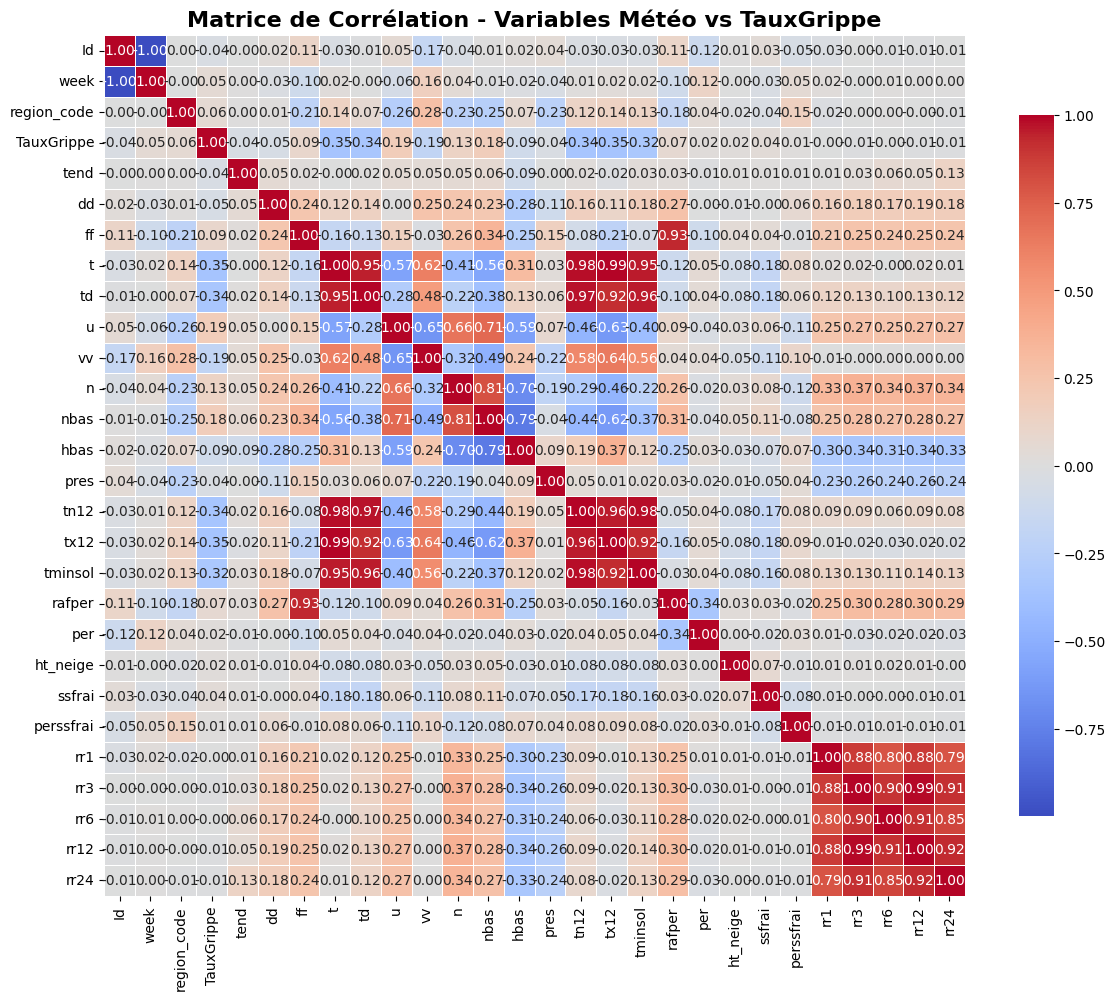


Corrélations avec TauxGrippe (triées) :
  u               : +0.186
  nbas            : +0.176
  n               : +0.129
  ff              : +0.089
  rafper          : +0.069
  region_code     : +0.059
  week            : +0.050
  ssfrai          : +0.039
  per             : +0.023
  ht_neige        : +0.021
  perssfrai       : +0.009
  rr6             : -0.004
  rr1             : -0.005
  rr12            : -0.012
  rr3             : -0.012
  rr24            : -0.014
  Id              : -0.035
  pres            : -0.038
  tend            : -0.043
  dd              : -0.051
  hbas            : -0.093
  vv              : -0.193
  tminsol         : -0.321
  td              : -0.341
  tn12            : -0.343
  t               : -0.353
  tx12            : -0.353


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# sélectionner uniquement les colonnes numériques
colonnes_numeriques = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# On calcule la matrice de corrélation des variables météo avec la variable cible 
correlation_matrix = df_clean[colonnes_numeriques].corr()

# Créer la visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Afficher les valeurs
            fmt='.2f',   # Format 2 décimales
            cmap='coolwarm',  # Palette de couleurs
            center=0,    # Centrer sur 0
            square=True, # Cases carrées
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Matrice de Corrélation - Variables Météo vs TauxGrippe', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Afficher les corrélations avec TauxGrippe triées
print("\nCorrélations avec TauxGrippe (triées) :")
correlations_grippe = correlation_matrix['TauxGrippe'].sort_values(ascending=False)
for var, corr in correlations_grippe.items():
    if var != 'TauxGrippe':
        print(f"  {var:15s} : {corr:+.3f}")

### ÉTAPE 7 : Créer le dataset avec variables sélectionnées

In [23]:
# variables sélectionnées basées sur l'analyse de corrélation
variables_selectionnees = ['tminsol', 'nbas', 'n', 'td', 'ff', 't', 'u', 'vv']

print(f"\nVariables à conserver (groupe réduit) :")
print(f"  - tminsol : température min du sol")
print(f"  - nbas : nébulosité des nuages niveau inférieur")
print(f"  - n : nébulosité totale")
print(f"  - td : point de rosée")
print(f"  - ff : vitesse du vent")
print(f"  - t : température")
print(f"  - u : humidité")
print(f"  - vv : visibilité horizontale")

# vérifier que toutes les variables existent
variables_disponibles = [var for var in variables_selectionnees if var in df_clean.columns]
variables_manquantes = [var for var in variables_selectionnees if var not in df_clean.columns]

print(f"\nVariables trouvées : {len(variables_disponibles)}/{len(variables_selectionnees)}")
if variables_manquantes:
    print(f"Variables non trouvées : {variables_manquantes}")

# créer df_reduit avec uniquement les variables sélectionnées
colonnes_obligatoires = ['TauxGrippe', 'region_code', 'region_name', 'week', 'date', 'saison']
df_reduit = df_clean[colonnes_obligatoires + variables_disponibles].copy()

print(f"\nDataset complet : {df_clean.shape}")
print(f"Dataset réduit (variables sélectionnées) : {df_reduit.shape}")
print(f"Colonnes du dataset réduit : {df_reduit.columns.tolist()}")


Variables à conserver (groupe réduit) :
  - tminsol : température min du sol
  - nbas : nébulosité des nuages niveau inférieur
  - n : nébulosité totale
  - td : point de rosée
  - ff : vitesse du vent
  - t : température
  - u : humidité
  - vv : visibilité horizontale

Variables trouvées : 8/8

Dataset complet : (9196, 31)
Dataset réduit (variables sélectionnées) : (9196, 14)
Colonnes du dataset réduit : ['TauxGrippe', 'region_code', 'region_name', 'week', 'date', 'saison', 'tminsol', 'nbas', 'n', 'td', 'ff', 't', 'u', 'vv']


### ÉTAPE 8 : Créer des features temporelles (lags et moyennes mobiles)

## SAUVEGARDE DES DATASETS FINAUX

In [24]:
#  Dataset complet (toutes les variables)
df_clean.to_csv('../data/processed/train_meteo_full.csv', index=False)
print("\n1. Dataset complet (toutes variables) :")
print(f"   Fichier : train_meteo_full.csv")
print(f"   Shape : {df_clean.shape}")
print(f"   Colonnes : {len(df_clean.columns)}")

#  Dataset réduit (variables sélectionnées)
df_reduit.to_csv('../data/processed/train_meteo_reduit.csv', index=False)
print("\n2. Dataset réduit (variables sélectionnées) :")
print(f"   Fichier : train_meteo_reduit.csv")
print(f"   Shape : {df_reduit.shape}")
print(f"   Colonnes : {df_reduit.columns.tolist()}")


1. Dataset complet (toutes variables) :
   Fichier : train_meteo_full.csv
   Shape : (9196, 31)
   Colonnes : 31

2. Dataset réduit (variables sélectionnées) :
   Fichier : train_meteo_reduit.csv
   Shape : (9196, 14)
   Colonnes : ['TauxGrippe', 'region_code', 'region_name', 'week', 'date', 'saison', 'tminsol', 'nbas', 'n', 'td', 'ff', 't', 'u', 'vv']


## RÉSUMÉ FINAL

In [25]:

print(f"  train_meteo_full.csv : {df_clean.shape[0]} lignes x {df_clean.shape[1]} colonnes")
print(f"  train_meteo_reduit.csv : {df_reduit.shape[0]} lignes x {df_reduit.shape[1]} colonnes")

print(f"\nVariables sélectionnées ({len(variables_disponibles)}) :")
for var in variables_disponibles:
    print(f"  - {var}")

  train_meteo_full.csv : 9196 lignes x 31 colonnes
  train_meteo_reduit.csv : 9196 lignes x 14 colonnes

Variables sélectionnées (8) :
  - tminsol
  - nbas
  - n
  - td
  - ff
  - t
  - u
  - vv
